In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.layers import Conv1D, TimeDistributed, Flatten, SpatialDropout1D, GlobalAveragePooling1D, SimpleRNN, MaxPooling1D, GlobalMaxPooling1D, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, f1_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, precision_score, classification_report
from numpy import sqrt
from numpy import argmax
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
from numpy import genfromtxt

In [6]:
def get_data():
    input_file = '/Users/niall/Documents/Cypress_Code/Data/Flip_bits/flip_bits_dataset_final.csv'
    my_data_flipped = genfromtxt(input_file, delimiter=',')

    new_data = np.delete(my_data_flipped, (0), axis=0)
    X2 = np.delete(new_data, (0,32), axis=1)
    Y2 = new_data[:,32]
    X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.25, random_state=42)
    X_train = np.array(X_train).reshape((np.shape(X_train)[0], 1, np.shape(X_train)[1]))
    X_test = np.array(X_test).reshape((np.shape(X_test)[0], 1, np.shape(X_test)[1]))

    return X_train, X_test, y_train, y_test

In [7]:
flip_bit_data = get_data()

In [8]:
X_train = flip_bit_data[0]
X_test = flip_bit_data[1]
y_train = flip_bit_data[2]
y_test = flip_bit_data[3]

# Build RNN Model

In [7]:
num_neurons = 31
num_features = 31

model_rnn = Sequential()
model_rnn.add(SimpleRNN(num_neurons, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, input_shape=(1, num_features)))
model_rnn.add(GlobalMaxPooling1D())
model_rnn.add(Dense(16, activation='sigmoid'))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(1, activation='sigmoid'))


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1, 31)             1953      
_________________________________________________________________
global_max_pooling1d (Global (None, 31)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                512       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 2,482
Trainable params: 2,482
Non-trainable params: 0
___________________

In [9]:
print('Training RNN...')

batch_size = 5
history_rnn = model_rnn.fit(X_train, y_train, 
                            batch_size=batch_size, 
                            epochs=5, 
                            validation_data=(X_test, y_test), 
                            callbacks=[rlrp],
                            verbose=1)

Training RNN...
Train on 450000 samples, validate on 150000 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/5
450000/450000 [==============================] - 156s 346us/sample - loss: 0.1002 - acc: 0.9630 - val_loss: 0.0427 - val_acc: 0.9862
Epoch 2/5
450000/450000 [==============================] - 154s 342us/sample - loss: 0.0945 - acc: 0.9650 - val_loss: 0.0456 - val_acc: 0.9836
Epoch 3/5
450000/450000 [==============================] - 155s 345us/sample - loss: 0.0942 - acc: 0.9652 - val_loss: 0.0382 - val_acc: 0.9861
Epoch 4/5
450000/450000 [==============================] - 162s 359us/sample - loss: 0.0930 - acc: 0.9657 - val_loss: 0.0452 - val_acc: 0.9835
Epoch 5/5
450000/450000 [==============================] - 170s 379us/sample - loss: 0.0927 - acc: 0.9657 - val_loss: 0.0424 - val_acc: 0.9868


150000/150000 [==============================] - 4s 25us/sample - loss: 0.0424 - acc: 0.98680s - loss: 0.0
Test Loss:  0.0423957122292618
Test Accuracy 0.98682
dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


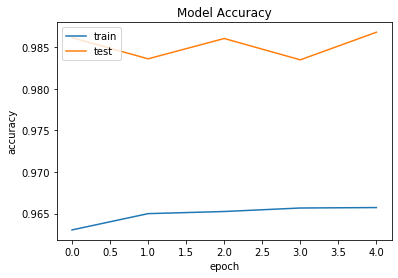

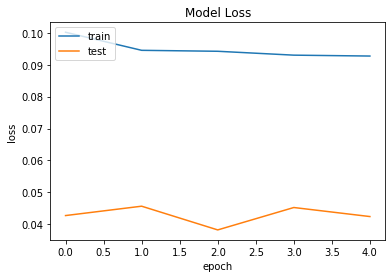

In [10]:
score = model_rnn.evaluate(X_test, y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])

print(history_rnn.history.keys())

plt.plot(history_rnn.history['acc'])
plt.plot(history_rnn.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
json = model_rnn.to_json()
with open("/Users/niall/Documents/Cypress_Code/Models/RNN/Flip_bits/model_one_rnn_flip_bits.json", "w") as file:
    file.write(json)
model_rnn.save_weights("/Users/niall/Documents/Cypress_Code/Models/RNN/Flip_bits/model_one_rnn_flip_bits.h5")
print("Saved model to disc")

Saved model to disc


In [9]:
# Load the model of interest
json_file = open('/Users/niall/Documents/Cypress_Code/Models/RNN/Flip_bits/model_one_rnn_flip_bits.json', 'r')
json = json_file.read()
json_file.close()
model_avg_from_disc = model_from_json(json)
model_avg_from_disc.load_weights("/Users/niall/Documents/Cypress_Code/Models/RNN/Flip_bits/model_one_rnn_flip_bits.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
y_preds_rnn = model_avg_from_disc.predict(X_test, batch_size=1)

In [10]:
pred_avg = pd.DataFrame(y_preds_rnn, columns =['Y_pred']) 
pred_avg['Label'] = y_test

In [11]:
pred_avg.to_csv('/Users/niall/Documents/Cypress_Code/Predictions/RNN/Flip_bits/model_one_rnn_flip_bits.csv', index = False)

In [22]:
yhat = model_avg_from_disc.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, yhat)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.404635, G-Mean=0.986


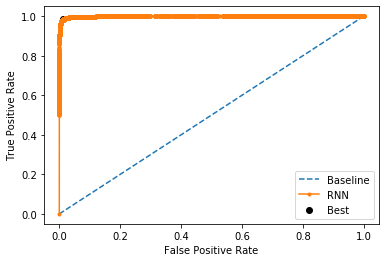

In [11]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Baseline')
plt.plot(fpr, tpr, marker='.', label='RNN')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.savefig('/Users/niall/Documents/Cypress_Code/Plots/Matlab_flip_bits/RNN_ROC.png')
plt.show()

In [23]:
auc = roc_auc_score(y_test, yhat)
print('ROC AUC=%.3f' % (auc))

ROC AUC=0.999


In [12]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))

In [21]:
yhat_new = model_avg_from_disc.predict_classes(X_test)
metrics(yhat_new, y_test)

F1-score:  0.9801738921146845
Precision:  0.9769896643409768
Recall:  0.9833789439793947
Acuracy:  0.98682
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    100304
           1       0.98      0.98      0.98     49696

    accuracy                           0.99    150000
   macro avg       0.98      0.99      0.99    150000
weighted avg       0.99      0.99      0.99    150000

